In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Aug 10 05:38:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#mounting google drive on colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
from scipy import signal

In [ ]:
X_train=np.load("./drive/MyDrive/MSc Thesis/Experiments/GraphWise_X_trainv7_exp1_strat.npy")
X_train_f=np.load("./drive/MyDrive/MSc Thesis/Experiments/GraphWise_X_f_trainv7_exp1_strat.npy")
y_train=np.load("./drive/MyDrive/MSc Thesis/Experiments/GraphWise_y_trainv7_exp1_strat.npy").astype(int)

X_test=np.load("./drive/MyDrive/MSc Thesis/Experiments/GraphWise_X_testv7_exp1_strat.npy")
X_test_f=np.load("./drive/MyDrive/MSc Thesis/Experiments/GraphWise_X_f_testv7_exp1_strat.npy")
y_test=np.load("./drive/MyDrive/MSc Thesis/Experiments/GraphWise_y_testv7_exp1_strat.npy").astype(int)


In [ ]:
print(X_train.shape)
print(X_train_f.shape)
print(y_train.shape)

print(X_test.shape)
print(X_test_f.shape)
print(y_test.shape)

(880, 20, 50, 4)
(880, 20, 26, 2)
(880, 20, 20)
(120, 20, 50, 4)
(120, 20, 26, 2)
(120, 20, 20)


In [ ]:
y_train1=y_train.reshape(y_train.shape[0],-1)
y_test1=y_test.reshape(y_test.shape[0],-1)

y_train1=np.expand_dims(y_train1,-1)
y_test1=np.expand_dims(y_test1,-1)

print(y_train1.shape)
print(y_test1.shape)

(880, 400, 1)
(120, 400, 1)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Input
from tensorflow.keras import layers
import keras
import tensorflow as tf
padding_dim=20
padding_val=1e6

In [ ]:
!pip install keras keras_nlp
import keras_nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 142 kB 9.1 MB/s 
     |████████████████████████████████| 4.6 MB 78.5 MB/s 
     |████████████████████████████████| 511.7 MB 5.3 kB/s 
     |████████████████████████████████| 511.7 MB 3.8 kB/s 
INFO: pip is looking at multiple versions of tensorflow-text to determine which version is compatible with other requirements. This could take a while.
     |████████████████████████████████| 4.9 MB 70.7 MB/s 


In [ ]:
padding_val=1e6

class out_adj_mat(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(out_adj_mat, self).__init__(**kwargs)

    def call(self, inputs):
        out1=tf.matmul(inputs,tf.transpose(inputs,[0,2,1]))#Loss
        out2=tf.keras.layers.Activation('sigmoid')(out1)#Actual output
        out1=tf.reshape(out1,(-1,20*20))
        out1=tf.expand_dims(out1,-1)
        return out1
    
    def compute_mask(self, inputs, mask=None):
        mask=tf.expand_dims(mask,axis=-1)
        mask=tf.cast(mask,tf.dtypes.int64)
        mask2=tf.matmul(mask,tf.transpose(mask,[0,2,1]))#Actual Output
        mask1=tf.experimental.numpy.triu(mask2,1)#Loss
        mask1=tf.cast(mask1,bool)
        mask1=tf.reshape(mask1,(-1,20*20))
        return mask1


# Part 2 - Building the RNN

# Importing the Keras libraries and packages

input_1 = Input((X_train.shape[1], X_train.shape[2], X_train.shape[3]),name="time") #20,50,4
input_2 = Input((X_train_f.shape[1], X_train_f.shape[2], X_train_f.shape[3]),name="freq") #20,26,2

x1=layers.Masking(mask_value=padding_val)(input_1)
x1=layers.TimeDistributed(LSTM(units = 100, return_sequences = True))(x1)
x1=layers.TimeDistributed(LSTM(units = 50))(x1)

x2=layers.Masking(mask_value=padding_val)(input_2)
x2=layers.TimeDistributed(LSTM(units = 100, return_sequences = True))(x2)
x2=layers.TimeDistributed(LSTM(units = 50))(x2)

merge_layer=layers.concatenate([x1,x2]) #B,20,100
x=keras_nlp.layers.TransformerEncoder(intermediate_dim=64, num_heads=4,dropout=0.1)(merge_layer)
x=keras_nlp.layers.TransformerEncoder(intermediate_dim=64, num_heads=4,dropout=0.1)(x)
x=keras_nlp.layers.TransformerEncoder(intermediate_dim=64, num_heads=4,dropout=0.1)(x)

out=out_adj_mat()(x)

classifier=keras.Model(inputs=[input_1, input_2], outputs=[out])

# # Compiling the RNN
classifier.compile(optimizer = 'adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics = 'accuracy')


In [ ]:
print(x1._keras_mask)
print(x2._keras_mask)
print(merge_layer._keras_mask)
print(x._keras_mask)
print(out._keras_mask)
# print(A_rec._keras_mask)

print(out)
# print(A_rec)

print(x)
print(tf.transpose(x,[0,2,1]))

KerasTensor(type_spec=TensorSpec(shape=(None, 20), dtype=tf.bool, name=None), name='Any:0')
KerasTensor(type_spec=TensorSpec(shape=(None, 20), dtype=tf.bool, name=None), name='Any:0')
KerasTensor(type_spec=TensorSpec(shape=(None, 20), dtype=tf.bool, name=None), name='All:0')
KerasTensor(type_spec=TensorSpec(shape=(None, 20), dtype=tf.bool, name=None), name='Placeholder_1:0')
KerasTensor(type_spec=TensorSpec(shape=(None, 400), dtype=tf.bool, name=None), name='Reshape:0')
KerasTensor(type_spec=TensorSpec(shape=(None, 400, 1), dtype=tf.float32, name=None), name='out_adj_mat/ExpandDims:0', description="created by layer 'out_adj_mat'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='transformer_encoder_2/layer_normalization_1/batchnorm/add_1:0', description="created by layer 'transformer_encoder_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100, 20), dtype=tf.float32, name=None), name='tf.compat.v1.transpose/transpose:0', description="created

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("./drive/MyDrive/MSc Thesis/Experiments/models/Transformer_1d_freq_exp1_strat_v8_v2.h5",
                             monitor="val_accuracy",
                             mode="max",
                             save_best_only = True,
                             verbose=1)


earlystop = EarlyStopping(monitor = 'val_accuracy', # value being monitored for improvement
                          min_delta = 0, #Abs value and is the min change required before we stop
                          patience = 50, #Number of epochs we wait before stopping 
                          verbose = 1,
                          restore_best_weights = True) #keeps the best weigths once stopped

# we put our call backs into a callback list
callbacks = [earlystop,checkpoint]


In [ ]:
classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 time (InputLayer)              [(None, 20, 50, 4)]  0           []                               
                                                                                                  
 freq (InputLayer)              [(None, 20, 26, 2)]  0           []                               
                                                                                                  
 masking (Masking)              (None, 20, 50, 4)    0           ['time[0][0]']                   
                                                                                                  
 masking_1 (Masking)            (None, 20, 26, 2)    0           ['freq[0][0]']                   
                                                                                              

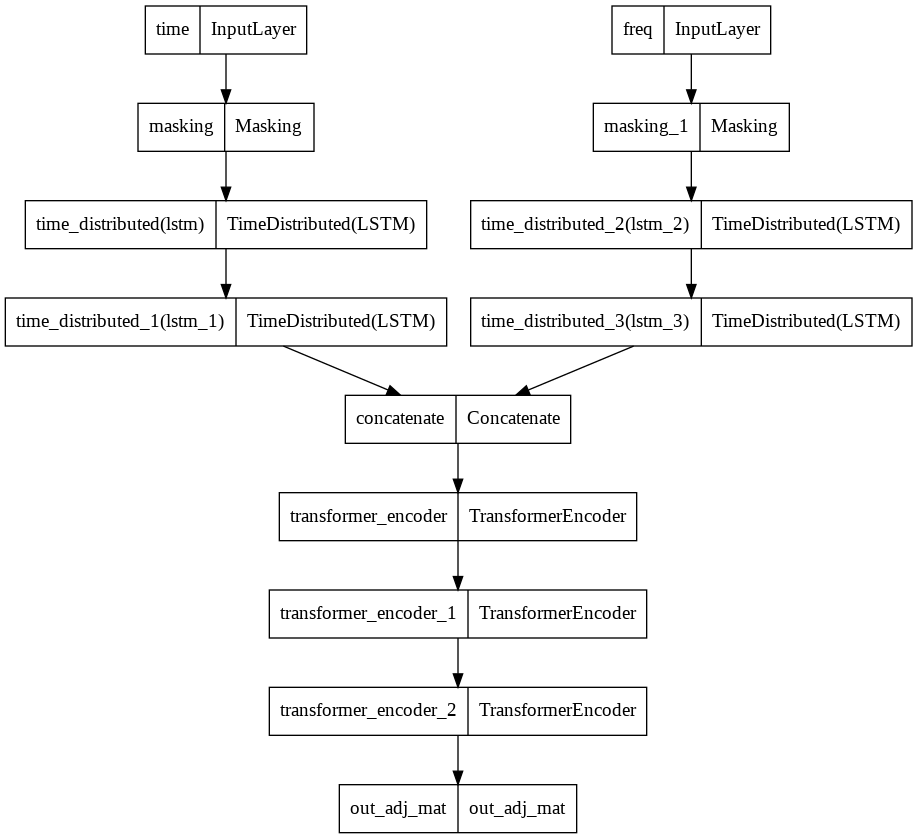

In [ ]:
tf.keras.utils.plot_model(classifier)

In [ ]:
# Fitting the RNN to the Training set
history=classifier.fit([X_train,X_train_f], y_train1, epochs = 500, batch_size = 64,validation_data=([X_test,X_test_f],y_test1),callbacks=callbacks)


Epoch 1/500
14/14 [==============================] - ETA: 0s - loss: 1.6995 - accuracy: 0.3246
Epoch 1: val_accuracy improved from -inf to 0.28806, saving model to ./drive/MyDrive/MSc Thesis/Experiments/models/Transformer_1d_freq_exp1_strat_v8_v2.h5
14/14 [==============================] - 32s 706ms/step - loss: 1.6995 - accuracy: 0.3246 - val_loss: 2.9805 - val_accuracy: 0.2881
Epoch 2/500


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


14/14 [==============================] - ETA: 0s - loss: 0.4116 - accuracy: 0.4608
Epoch 2: val_accuracy improved from 0.28806 to 0.33738, saving model to ./drive/MyDrive/MSc Thesis/Experiments/models/Transformer_1d_freq_exp1_strat_v8_v2.h5
14/14 [==============================] - 4s 272ms/step - loss: 0.4116 - accuracy: 0.4608 - val_loss: 2.4651 - val_accuracy: 0.3374
Epoch 3/500
14/14 [==============================] - ETA: 0s - loss: 0.3387 - accuracy: 0.5083
Epoch 3: val_accuracy improved from 0.33738 to 0.40279, saving model to ./drive/MyDrive/MSc Thesis/Experiments/models/Transformer_1d_freq_exp1_strat_v8_v2.h5
14/14 [==============================] - 4s 273ms/step - loss: 0.3387 - accuracy: 0.5083 - val_loss: 2.1908 - val_accuracy: 0.4028
Epoch 4/500
14/14 [==============================] - ETA: 0s - loss: 0.3030 - accuracy: 0.5387
Epoch 4: val_accuracy improved from 0.40279 to 0.45533, saving model to ./drive/MyDrive/MSc Thesis/Experiments/models/Transformer_1d_freq_exp1_strat_

In [ ]:
classifier.evaluate([X_test,X_test_f],y_test1)

4/4 [==============================] - 0s 34ms/step - loss: 0.0274 - accuracy: 0.9214


[0.02736184000968933, 0.9213724136352539]

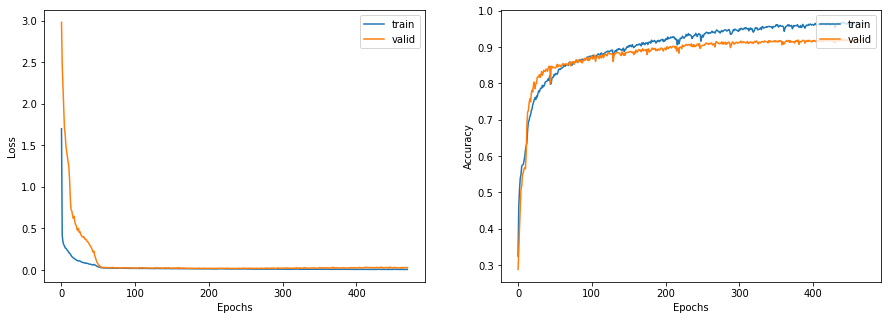

In [ ]:
import matplotlib.pyplot as plt
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "valid"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["accuracy"])
    ax2.plot(history.history["val_accuracy"])
    ax2.legend(["train", "valid"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

display_learning_curves(history)

In [ ]:
import tensorflow as tf
temp=tf.keras.models.load_model("./drive/MyDrive/MSc Thesis/Experiments/models/Transformer_1d_freq_exp1_strat_v8_v2.h5",
                                custom_objects={'TransformerEncoder': keras_nlp.layers.TransformerEncoder(intermediate_dim=64, num_heads=4,dropout=0.1),
                                                'out_adj_mat':out_adj_mat()})

In [ ]:
temp.evaluate([X_test,X_test_f], y_test1, 1)

120/120 [==============================] - 8s 31ms/step - loss: 0.0274 - accuracy: 0.9214


[0.027361834421753883, 0.9213724136352539]

In [ ]:
from tqdm.notebook import tqdm
true=[]
pred=[]
for i in tqdm(range(len(y_test1))):
  result=temp([X_test[i:i+1],X_test_f[i:i+1]])
  true=true+list(y_test1[i,:,0][result._keras_mask[0,:]])
  temp_pred=np.array(result[result._keras_mask][:,0])
  temp_pred[temp_pred>=0]=1
  temp_pred[temp_pred<0]=0
  pred=pred+list(temp_pred)

  0%|          | 0/120 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report,confusion_matrix

In [ ]:
confusion_matrix(true,pred)

array([[1799,  195],
       [  31,  773]])

In [ ]:
accuracy_score(true,pred)

0.9192280200142959

In [ ]:
f1_score(true,pred)

0.8724604966139955

In [ ]:
print(classification_report(true,pred))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94      1994
           1       0.80      0.96      0.87       804

    accuracy                           0.92      2798
   macro avg       0.89      0.93      0.91      2798
weighted avg       0.93      0.92      0.92      2798

